# Seed-based FC


**Resources**

[Nilearn 9.4.6. Producing single subject maps of seed-to-voxel correlation](https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html#sphx-glr-auto-examples-03-connectivity-plot-seed-to-voxel-correlation-py)

[Nilearn: 9.5.4. Default Mode Network extraction of AHDH dataset](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_adhd_dmn.html)

[FitLins](https://github.com/poldracklab/fitlins)

HC coordinates from Sherman (2015): 'Analyses focused on a priori defined region of the anterior hippocampus (MNI coordinates: x = -21, y = -9, z = -15) because of its importance to retrieval of relational memory (Giovanello et al., 2009) and sensitivity to prior sleep physiology (Mander et al., 2013a).'

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import warnings
warnings.filterwarnings('ignore')

from nilearn import plotting
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix
from nilearn import input_data

tr = 1.5  
n_scans = 164  
frame_times = np.arange(n_scans) * tr  
hc_coords = [(-21, -9, -15)]
runs = ['1', '2', '3']

In [2]:
func_files = sorted(glob.glob('/Volumes/psybrain/ADM/derivatives/fmriprep/sub-*/func/sub-*_task-MemMatch[1-3]_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
func_files[:5]

['/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch1_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch3_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30008/func/sub-30008_task-MemMatch1_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30008/func/sub-30008_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

In [4]:
conf_files = sorted(glob.glob('/Volumes/psybrain/ADM/derivatives/fmriprep/sub-*/func/sub-*_task-MemMatch[1-3]_run-01_desc-confounds_regressors.tsv'))
conf_files[:5]

['/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch1_run-01_desc-confounds_regressors.tsv',
 '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch2_run-01_desc-confounds_regressors.tsv',
 '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch3_run-01_desc-confounds_regressors.tsv',
 '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30008/func/sub-30008_task-MemMatch1_run-01_desc-confounds_regressors.tsv',
 '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30008/func/sub-30008_task-MemMatch2_run-01_desc-confounds_regressors.tsv']

In [174]:
subjects = np.unique([ func_file.split('sub-')[1][:5] for func_file in func_files])
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/seed-based_fc/subjects.txt', subjects, fmt = '%s')
subjects[:5]

array(['30004', '30008', '30009', '30012', '30015'], dtype='<U5')

## First level GLM

In [120]:
hrf_model = 'spm + derivative'
selected_confounds = ['a_comp_cor_00', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'motion_outlier_00']

In [151]:
seed_masker = input_data.NiftiSpheresMasker(
    hc_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=tr,
    memory='nilearn_cache', memory_level=1, verbose=0)

brain_masker = input_data.NiftiMasker(
            smoothing_fwhm=6,
            detrend=True, standardize=True,
            low_pass=0.1, high_pass=0.01, t_r=tr,
            memory='nilearn_cache', memory_level=1, verbose=0)


subject: 30004
run: 1


/usr/local/lib/python3.7/site-packages/nilearn/_utils/glm.py:309: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


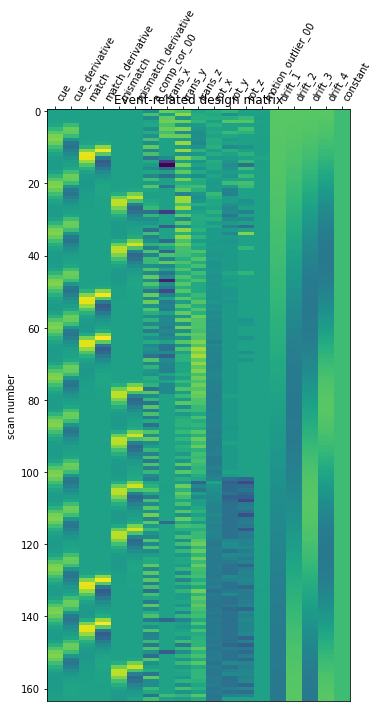

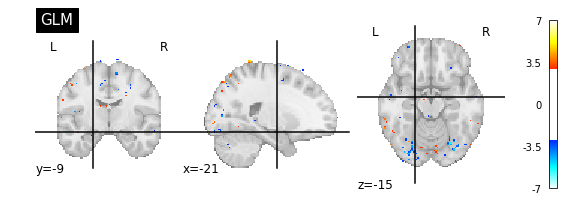

/usr/local/lib/python3.7/site-packages/nilearn/glm/regression.py:49: FutureWarning: 'resid' has been deprecated in version 0.7.0 and will be removed in version 0.9.0. Please use 'residuals' instead.
  new_param


In [ ]:
i = 0

for subject in subjects:
    
    print('subject: %s' % subject)
    
    for run in runs:
        
        print('run: %s' % run)
        
        try:
        
            func_file = '/Volumes/psybrain/ADM/derivatives/fmriprep/sub-%s/func/sub-%s_task-MemMatch%s_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (subject, subject, run)

            confounds_ = pd.read_csv('/Volumes/psybrain/ADM/derivatives/fmriprep/sub-%s/func/sub-%s_task-MemMatch%s_run-01_desc-confounds_regressors.tsv' % (subject, subject, run), 
                                    sep = '\t')[selected_confounds]

            # create design matrix from events file and regress out motion confounds
            X1 = make_first_level_design_matrix(
                frame_times, events[['trial_type', 'onset', 'duration']],
                add_regs=confounds_, hrf_model=hrf_model)

            if i == 0:

                plot_design_matrix(X1)
                plt.title('Event-related design matrix', fontsize=12)
                plt.show()

                # contrast is 1 for cue period and 0 for other trial types and motion confounds
                cue_contrast = np.array([1] + [0] * (X1.shape[1] - 1))
                contrasts = {'cue': cue_contrast}

            # calculate first level model
            first_level_model = FirstLevelModel(t_r=tr, slice_time_ref=0, minimize_memory=False)
            first_level_model = first_level_model.fit(run_imgs='/Volumes/psybrain/ADM/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch1_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
                                                design_matrices=X1)

            z_map = first_level_model.compute_contrast(contrasts['cue'],
                                               output_type='z_score')

            display = plotting.plot_stat_map(z_map, threshold=3.0, title='GLM', 
                                     cut_coords=(-21, -9, -15))

            plt.show()

            first_level_model.residuals[0].to_filename(
                '/Volumes/schnyer/Megan/adm_mem-fc/analysis/seed-based_fc/sub-%s_task-MemMatch%s_cue_residuals.nii.gz' %
            (subject, run))
        
        except Exception as e:
            
            print(e)
        
       

```bash

 fslmerge <-x/y/z/t/a/tr> <output> <file1 file2 .......> [tr value in seconds]
     -t : concatenate images in time
     -x : concatenate images in the x direction
     -y : concatenate images in the y direction
     -z : concatenate images in the z direction
     -a : auto-choose: single slices -> volume, volumes -> 4D (time series)
     -tr : concatenate images in time and set the output image tr to the final option value
     -n <N> : only use volume <N> from each input file (first volume is 0 not 1)


```

In [ ]:
%%bash

out_dir=/Volumes/schnyer/Megan/adm_mem-fc/analysis/seed-based_fc

for subject in `cat /Volumes/schnyer/Megan/adm_mem-fc/analysis/seed-based_fc/subjects.txt | head -1`; do
    echo $subject
    if [ ! -f ${out_dir}/sub-${subject}_task-MemMatch_run-concat_cue_residuals.nii.gz ]; then
      fslmerge -t ${out_dir}/sub-${subject}_task-MemMatch_run-concat_cue_residuals.nii.gz ${out_dir}/sub-${subject}_task-MemMatch1_cue_residuals.nii.gz ${out_dir}/sub-${subject}_task-MemMatch2_cue_residuals.nii.gz ${out_dir}/sub-${subject}_task-MemMatch3_cue_residuals.nii.gz
    fi
done

In [178]:
164*3

492

In [177]:
%%bash

out_dir=/Volumes/schnyer/Megan/adm_mem-fc/analysis/seed-based_fc

fslinfo ${out_dir}/sub-30004_task-MemMatch_run-concat_cue_residuals.nii.gz

data_type	FLOAT64
dim1		97
dim2		115
dim3		97
dim4		492
datatype	64
pixdim1		2.000000
pixdim2		2.000000
pixdim3		2.000000
pixdim4		1.000000
cal_max		0.000000
cal_min		0.000000
file_type	NIFTI-1+


In [ ]:
i = 0

resid_files = sorted(glob.glob(
     '/Volumes/schnyer/Megan/adm_mem-fc/analysis/seed-based_fc/sub-*_task-MemMatch_run-concat_cue_residuals.nii.gz'))
    
for resid_file in resid_files:
    
    print(resid_file)
    
    subject = resid_file.split('sub-')[1][:5]
    
    print('subject: %s' % subject)
    
    try: 
        # extract residuals time series from hc roi
        seed_time_series = seed_masker.fit_transform(resid_file)

        # extract residuals time series from brain
        brain_time_series = brain_masker.fit_transform(resid_file)

        if i == 0:
            print("Seed time series shape: (%s, %s)" % seed_time_series.shape)
            print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

        plt.plot(seed_time_series)
        plt.title('sub-%s, Seed residuals (Hippocampus)' % subject)
        plt.xlabel('Scan number')
        plt.ylabel('Normalized signal')
        plt.tight_layout()
        plt.show()

        seed_to_voxel_correlations = (np.dot(brain_time_series.T, seed_time_series) /
                              seed_time_series.shape[0]
                              )

        seed_to_voxel_correlations_img = brain_masker.inverse_transform(seed_to_voxel_correlations.T)

        seed_to_voxel_correlations_img.to_filename(
            '/Volumes/schnyer/Megan/adm_mem-fc/analysis/seed-based_fc/sub-%s_task-MemMatch_run-concat_seed-hc_seed_correlation.nii.gz' %
        (subject))

        display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
                                         threshold=0.4, vmax=1,
                                         cut_coords=hc_coords[0],
                                         title="sub-%s Seed-to-voxel correlation (HC seed)" % subject
                                         )

        display.add_markers(marker_coords=hc_coords, marker_color='g',
                            marker_size=200)

        display.savefig('/Volumes/schnyer/Megan/adm_mem-fc/analysis/seed-based_fc/sub-%s_task-MemMatch_run-concat_seed-hc_seed_correlation.pdf' %
                       (subject))

        plt.show()

        i += 1

        plt.close()
    
    except Exception as e:
        
        print(e)
        
        